## EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mbti = pd.read_csv('data/train.csv')

# List of mbti types 
type_labels = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 
               'ISTP', 'ISFP', 'INFP', 'INTP', 
               'ESTP', 'ESFP', 'ENFP', 'ENTP', 
               'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ']

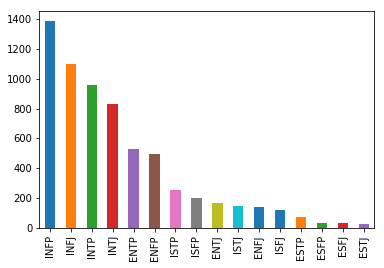

In [4]:
mbti['type'].value_counts().plot(kind = 'bar')


Lets increase the size of the dataset by converting each of the 50 posts into the `posts` column into its own row.

In [5]:

all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

In [6]:
print(f"before:  {mbti.shape} \nafter: {all_mbti.shape}")

before:  (6506, 2) 
after: (316548, 2)


In [7]:
pd.concat([mbti['type'].value_counts().to_frame(name='before'), all_mbti['type'].value_counts().to_frame(name='after')],axis=1)

,before,after
ENFJ,143,6947
ENFP,496,23925
ENTJ,167,8174
ENTP,530,26017
ESFJ,35,1668
ESFP,36,1663
ESTJ,30,1495
ESTP,71,3437
INFJ,1100,53807
INFP,1386,67846


In [8]:
all_mbti.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


### Note: find out sampling with replacement

---

---
## create features


 feature | regex
 ---|---
 `?`   | `r"(\?)"`
 `!`   | `r"(!)"`
 `...` | `r"(\.\.\.)"`
 youtube | ?part of social media
 www | `r"(www)"`
 jpg/jpeg/gif | <code>r"(jpe?g&#124;gif)"</code>
 emoji `;), :tongue:, :smile: #hastags?` | `r":[a-z]*:"`
 word count   | (\w+) / 50 (length per post sample)
 word_length > 5   | `r"(\w{5,})"`
 social_media (instagram, snapchat, etc)  | [social_medai]
 ALL_CAPS  | `r"(\b[A-Z]{2,}\b)"`


In [9]:
# trial functions
# data_trial1, data_trial2, data_trial3 


In [11]:
data_trial2 = all_mbti['post'].loc[1]

In [12]:
data_trial3 = all_mbti['post'].loc[369]

In [13]:
data_trial1 = all_mbti['post'].loc[42]

In [14]:
import re

In [15]:
# count question marks
def qm_count(string):
    q_mark = re.compile(r'(\?)')
    return len(re.findall(q_mark, string))
    

In [16]:
qm_count(data_trial3)

0

In [17]:
def exclaim_count(string):
    ex_mark = re.compile(r'(\!)')
    return len(re.findall(ex_mark, string))

In [18]:
exclaim_count(data_trial3)

0

In [19]:
def elipse_count(string):
    elipse = re.compile(r"(\.\.\.)")
    return len(re.findall(elipse, string))

In [20]:
elipse_count(data_trial1)

0

In [21]:
def emoji_count(string):
    emojis = re.compile(r"(:[a-z]*:)|([:;][()pdo03])",re.I)
    return len(re.findall(emojis,string))

In [22]:
emoji_count(data_trial3)

0

In [34]:
def word_count(string):
    words = re.compile(r"(\w+)")
    count = len(re.findall(words, string))
    return count

In [35]:
word_count(data_trial3)

32

In [36]:
def word_len(string):
    len5 = re.compile(r"\w{5,}")
    return len(re.findall(len5,string))

In [37]:
word_len(data_trial3)

13

In [29]:
def all_caps(string):
    mbti_type = set(all_mbti.type) # set of all mbti types
    capsloc = re.compile(r"\b[A-Z]{2,}\b")
    caps_words = [x for x in re.findall(capsloc,string) if x not in mbti_type]
    return len(caps_words)

In [39]:
all_caps(data_trial3)

0

In [31]:
def count_pix(string):
    pix = re.compile(r"\b(jpe?g|gif|png|img)\b",re.I)
    return len(re.findall(pix, string))

In [32]:
count_pix(data_trial2)

1

In [41]:
def create_features(df):
    df['questions'] = df['post'].apply(qm_count)
    df['exclaimed'] = df['post'].apply(exclaim_count)
    df['elipses'] = df['post'].apply(elipse_count)
    df['emojis'] = df['post'].apply(emoji_count)
    df['word_count'] = df['post'].apply(word_count)
    df['big_words'] = df['post'].apply(word_len)
    df['images'] = df['post'].apply(count_pix)    
    df['words_all_caps'] = df['post'].apply(all_caps) 

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore warning messages cluttering up view
    create_features(all_mbti)

In [ ]:
all_mbti.head(10)

---

### FeatureUnion to add created features to the data pipeline

https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments/code

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

start by doing individual columns, then see if we can combine them

---
## Sklearn pipeline
```
imports

steps= [('count_vec','CountVectorizer()),
        ('SVM', SVM())]
       
pipeline= Pipeline(steps)

parameters = {'SVM__C': [1,10,100],
              'SVM__gamma': [0.1,0.01]}
              
train, test split

cv = GrisSearchCV(pipeline,parameters) #default cv=5

cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)

"best params" cv.best_params_

"Accuracy" cv.score(X_test,y_test)

classification_report(y_test,y_pred)
```

### Imports

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#CountVectorizer followed by TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer 

In [11]:
# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

others: logistic, linearSVM or SGDClassifier (esp for gridsearchcv)

#### Train, Test split

In [1]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_mbti['post'], all_mbti['type'], test_size=0.3, random_state=42)

#### my own stopwords list

In [69]:
my_stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren',
"aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can',
'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't",
'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't",
'have', 'haven', "haven't", 'having',  'how', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its',
'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'needn',
"needn't", 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've",
'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'then', 'there', 'these',
'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we',
'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with',
'won', "won't", 'wouldn', "wouldn't", 'y','ISTJ', 'ISFJ', 'INFJ', 'INTJ', 
               'ISTP', 'ISFP', 'INFP', 'INTP', 
               'ESTP', 'ESFP', 'ENFP', 'ENTP', 
               'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ']

### Pipelines

try different classifyers

In [15]:
from sklearn.pipeline import Pipeline

In [78]:
# baseline
pipe1 = Pipeline([('count_vec',CountVectorizer(stop_words=my_stopwords,ngram_range=(1,2))),
                  ('bayes',MultinomialNB())])

In [79]:
pipe1.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('count_vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', ...izer=None, vocabulary=None)), ('bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [80]:
y_pred= pipe1.predict(X_test)

In [81]:
pipe1.score(X_test,y_test)

0.2547991365239825

In [82]:
from sklearn.metrics import classification_report

In [83]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

       ENFJ       0.00      0.00      0.00      2155
       ENFP       0.48      0.01      0.02      7282
       ENTJ       0.00      0.00      0.00      2449
       ENTP       0.44      0.02      0.04      7831
       ESFJ       0.00      0.00      0.00       464
       ESFP       0.00      0.00      0.00       493
       ESTJ       0.00      0.00      0.00       458
       ESTP       0.00      0.00      0.00      1041
       INFJ       0.26      0.25      0.25     16233
       INFP       0.24      0.84      0.38     20278
       INTJ       0.39      0.07      0.12     11856
       INTP       0.34      0.14      0.20     13981
       ISFJ       0.33      0.00      0.00      1798
       ISFP       1.00      0.00      0.01      2825
       ISTJ       1.00      0.00      0.00      2123
       ISTP       0.50      0.00      0.00      3698

avg / total       0.34      0.25      0.17     94965



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
from sklearn.metrics import confusion_matrix

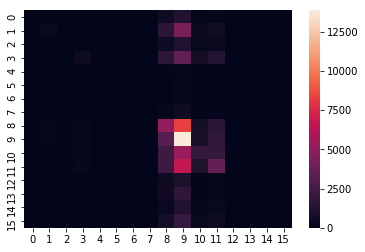

In [27]:
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test,y_pred))

---